<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Environment" data-toc-modified-id="Environment-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Environment</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#N-Param" data-toc-modified-id="N-Param-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>N Param</a></span></li><li><span><a href="#Prior-Samples" data-toc-modified-id="Prior-Samples-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Prior Samples</a></span></li></ul></li><li><span><a href="#Trained-Prior" data-toc-modified-id="Trained-Prior-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Trained Prior</a></span></li><li><span><a href="#Posterior" data-toc-modified-id="Posterior-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Posterior</a></span></li></ul></div>

# Tutorial 1 : Conditional Neural Processes - 1D GP Data

Last Update : 27 August 2019

**Aim**: 
- Training a simple [conditional neural process](https://arxiv.org/pdf/1807.01613.pdf) (CNP)
- Learning how to use the library to build more complicated models
- See how well a CNP "learns" a GP kernel

**Nota Bene:**
- Not much hyper-parameter tuning done
- Architecture differs slightly from the paper to be more general and modularizable for future work.

**Environment Hyper-parameters:**

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False  # can also be set in the trainer

## Environment

In [2]:
cd ..

/private/home/yannd/projects/NPF


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch

# CENTER PLOTS
from IPython.core.display import HTML

display(
    HTML(
        """ <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""
    )
)

if IS_FORCE_CPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

sys.path.append("notebooks")

torch.set_num_threads(N_THREADS)

## Dataset

The dataset we will be using are simple functions sampled from different Gaussian kernel with varying hyper-parameters. See the docstrings of `GPDataset` for more details. 

**Details**
- $x \in \mathbb{R}^1$, $y \in \mathbb{R}^1$
- I will be using the following kernels ([Details in sklearn docs](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes)): 
    - Squared Exponential
    - Matern
    - Matern with noise
    - Exp-Sine-Squared (periodic)
- Points are sampled randomly between (-2, 2) but scaled in (-1,1) as inputs to the model (worked just as well without rescaling but slightly easier to code for more advance things).
- At every epoch we precompute randomly sampled functions, so the model never sees the same function twice.
- `num_points` is the number of sampled points for a single sampled function
- `num_samples` is the number of sample functions which corresponds to the size of the dataset for one epoch.
- For each combination of input features `X` and kernel hyper-parameters, `n_same_samples` different target functions are sampled to make sampling much quicker.

**Extensions**

- Adding a dataset from a new kernel is straightforward by defining your own [kernel](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes).

In [ ]:
X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 50000

In [5]:
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel,
    DotProduct,
    ExpSineSquared,
    Matern,
    WhiteKernel,
)

from utils.data import GPDataset, DIR_DATA


def get_gp_datasets_varying(n_samples=10000, n_points=128, save_file=f"{os.path.join(DIR_DATA, 'gp_dataset.hdf5')}", **kwargs):
    """
    Return different 1D functions sampled from GPs with the following kernels:
    "rbf", "periodic", "non-stationary", "matern", "noisy-matern" with varying
    hyperparameters.
    """
    datasets = dict()
    kwargs.update(dict(n_samples=n_samples, n_points=n_points, is_vary_kernel_hyp=True))

    def add_dataset_(name, kernel, save_file=save_file):
        if save_file is not None:
            save_file = (save_file, name)
        datasets[name] = GPDataset(kernel=kernel, save_file=save_file, **kwargs)

    add_dataset_("RBF_Kernel", RBF(length_scale_bounds=(0.02, 0.3)))
    add_dataset_(
        "Periodic_Kernel",
        ExpSineSquared(length_scale_bounds=(0.2, 0.5), periodicity_bounds=(0.5, 2.0)),
    )
    add_dataset_("Matern_Kernel", Matern(length_scale_bounds=(0.03, 0.3), nu=1.5))
    add_dataset_(
        "Noisy_Matern_Kernel",
        (
            WhiteKernel(noise_level_bounds=(0.05, 0.7))
            + Matern(length_scale_bounds=(0.03, 0.3), nu=1.5)
        ),
    )
    
    datasets_test = {k:dataset.get_samples(save_file=save_file, idx_chunk=-1) for k,dataset in datasets.items()}

    return datasets, datasets_test

In [6]:
datasets, datasets_test = get_gp_datasets_varying(
    n_samples=N_SAMPLES, n_points=N_POINTS
)  # save dataset to make experimentation quicker but memory ++

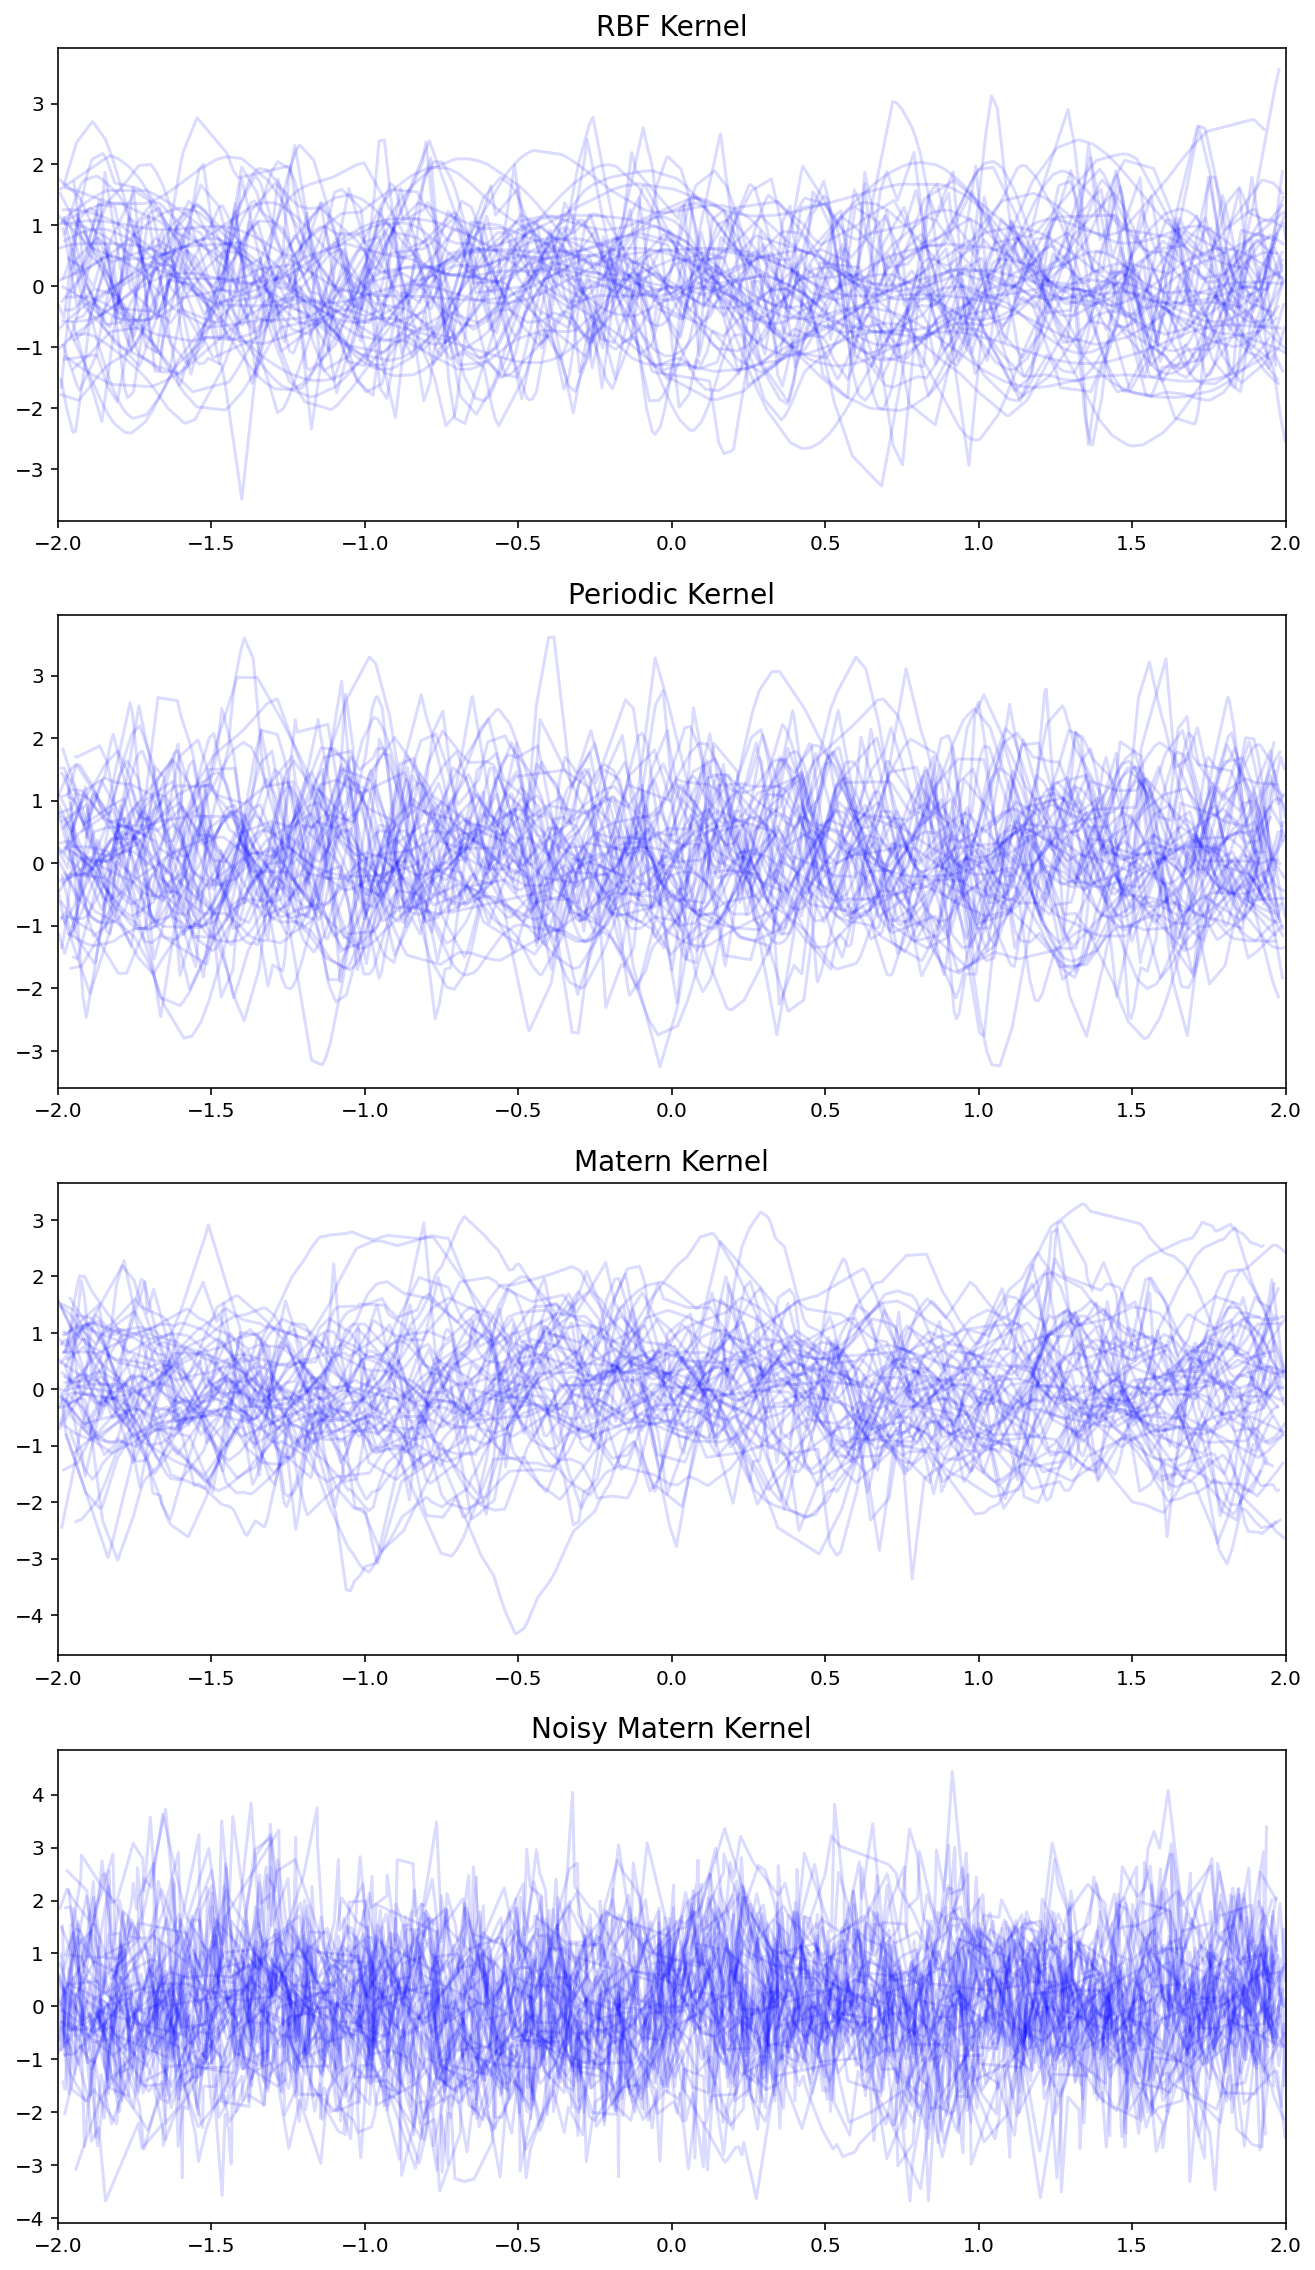

In [7]:
from utils.visualize import (
    plot_dataset_samples_1d,
    plot_losses,
    plot_posterior_samples_1d,
    plot_prior_samples_1d,
)

n_datasets = len(datasets)
fig, axes = plt.subplots(n_datasets, 1, figsize=(11, 5 * n_datasets))
for i, (k, dataset) in enumerate(datasets.items()):
    plot_dataset_samples_1d(dataset, title=k.replace("_", " "), ax=axes[i])

Let's define the context and target splitters. Here, we select uniformly between 0.01 and 0.5 context points and use all points as target. 

In [8]:
from neuralproc.utils.datasplit import CntxtTrgtGetter, GetRandomIndcs, get_all_indcs

get_cntxt_trgt = CntxtTrgtGetter(
    contexts_getter=GetRandomIndcs(min_n_indcs=0.01, max_n_indcs=0.5),
    targets_getter=get_all_indcs,
)

## Model

Neural Processes Family (NPFs) are a family of models, which uses a set neural network to estimate the conditional predictive distribution $p(\mathrm{Y}_\mathcal{T} | \mathrm{X}_\mathcal{T}, \mathcal{C})$ over a set of *target* values $\mathrm{Y}_\mathcal{T} := \{\mathbf{y}^{(t)}\}_{t=1}^T$
conditioned on a set of corresponding target features $\mathrm{X}_\mathcal{T} := \{\mathbf{x}^{(t)}\}_{t=1}^T$ and a *context* set of feature-value pairs $\mathcal{C} := \{(\mathbf{x}^{(c)}, \mathbf{y}^{(c)})\}_{c=1}^C$ . 
In this series of notebooks, I will try to describe NPFs under a unifying framework. From a computation perspective, the family of models have three main components:

* The **encoder** $h_{\pmb{\theta}}$ takes as input a context point $(\mathbf{x}^{(c)}, \mathbf{y}^{(c)})$ and embeds it as $\mathbf{r}_c \in \mathbb{R}^d$. Typically, it is modeled as a multi-layer perceptron (MLP).

* The **aggregator** outputs a representation $\mathbf{r}_\mathcal{C}^{(t)} \in \mathbb{R}^d$, given all context embeddings $\{\mathbf{r}_c\}_{c=1}^C$ and a target features $\mathbf{x}^{(t)}$. As the input is an unordered set, the aggregator should be *permutation invariant* in $\mathcal{C}$. 
Importantly, the dimensionality of $\mathbf{r}_\mathcal{C}^{(t)}$ is independent of the cardinality $|\mathcal{C}|$, which is essentially NPFs are more computationally efficient (at test time) than proper stochastic processes like [Gaussian Processes](https://en.wikipedia.org/wiki/Gaussian_process).
Standard CNPs use a mean aggregation, which is independent of the target position
$\mathbf{r}_\mathcal{C}^{(t)} = \frac{1}{C} \sum_{c=1}^C \mathbf{r}_c$.

* The **decoder** predicts a distribution over target values $\mathbf{y}^{(t)}$, conditioned on $\mathbf{r}_\mathcal{C}^{(t)}$ and $\mathbf{x}^{t}$. This is achieved through a neural network $g_{\pmb\theta}$, which outputs sufficient statistics $\pmb\phi^{(t)}$ of a Gaussian probability density function (PDF).

Formally:

$$
\begin{align}
p(\mathrm{Y}_\mathcal{T} | \mathrm{X}_\mathcal{T}, \mathcal{C}) 
&\approx Q_{\pmb\theta}(\mathrm{Y}_\mathcal{T} | \mathrm{X}_\mathcal{T}, \mathcal{C}) \label{eq::cnp_approx} \\
&= \prod_{t=1}^{T} Q_{\pmb\theta}(\mathbf{y}^{(t)} | \mathbf{x}^{(t)}, \mathcal{C})\label{eq::cnp_factor} \\
&= \prod_{t=1}^{T} Q_{\pmb\theta}(\mathbf{y}^{(t)} | \mathbf{r}_t, \mathbf{r}_\mathcal{C}^{(t)})\label{eq::cnp_rc} \\
&= \prod_{t=1}^{T} p(\mathbf{y}^{(t)} | \pmb\phi^{(t)})
\end{align}
$$

Where:

$$
\begin{align}
\mathbf{r}_c
&:= h_{\pmb\theta}(\mathbf{x}^{(c)}, \mathbf{y}^{(c)}) \label{eq::cnp_def_rc}
\\
\mathbf{r}_\mathcal{C}^{(t)}
&:= \mathrm{Agg}\left( \mathbf{r}_t, \{\mathbf{r}_c\}_{c=1}^{C} \right) \label{eq:cnp_def_agg}\\
\pmb\phi^{(t)} 
&:= g_{\pmb\theta}(  \mathbf{r}_t,\mathbf{r}_\mathcal{C}^{(t)}) \label{eq::cnp_def_phi} \\
\mathbf{r}_t
&:= h_{\pmb\theta}(\mathbf{x}^{(c)}) \label{eq::cnp_def_rt}
\end{align}
$$

The following figure shows the unifying NPF computational graph, as well as the specific aggregator module for Conditional NP | NP | Attentive NP. 

In [9]:
from IPython.display import Image

#Image(filename="imgs/Neural Process Family.jpg")

The general model architecture is slightly different from the paper to make it modular and easy to extend. See the docstrings of `NeuralProcess` for more details.

Nota Bene: Although hyperparameters have been tested I haven't ran any hyperparameter optimization yet. 

**Main Parameters : Conditional Neural Process**
- `r_dim` : Dimension $d$ of hidden representations $r \in \mathbb{R}^d$.
- `XEncoder` : Spatial encoder module which maps $\{x^{(i)}\} \to \{x_{transformed}^{(i)}\}$. Example:
    - `MLP` : will learn positional embeddings with MLP
    - `SinusoidalEncodings` : use sinusoidal positional encodings.
    - `Identity` : this is what they use in the paper but it doesn't work as well (less parameter sharing)
- `XYEncoder` : Encoder module which maps $\{x_{transformed}^{(i)}, y^{(i)}\} \to \{r^{(i)}\}$. Example:
    - `merge_flat_input(MLP, is_sum_merge=False)` : learn representation with MLP. `merge_flat_input` concatenates (or sums) X and Y inputs.
    - `merge_flat_input(SelfAttention, is_sum_merge=True)` : self attention mechanisms (as [Attentive Neural Process]). For more parameters (attention type, number of layers ...) refer to its docstrings.
    - `discard_ith_arg(MLP, 0)` if want the encoding to only depend on Y.
- `Decoder` : Decoder module which maps $\{r, x^{(*)}\} \to \{\hat{y}^{(*)}\}$. Example:
    - `merge_flat_input(MLP)` : predict with MLP.
    - `merge_flat_input(SelfAttention, is_sum_merge=True)` : predict with self attention mechanisms to have coherant predictions (not use in attentive neural process [Attentive Neural Process], but in [Image Transformer]). 
    - `discard_ith_arg(MLP, 0)` if want the decoding to only depend on $r$.
    

**Extensions**

- For Neural Process, see the [Tutorial 2 - Neural Process] notebook.
- For Attentive Neural Process, see the [Tutorial 3 - Attentive Neural Process] notebook.
- For Conditional Convolutional Process, see the [Tutorial 4 - Conditional Convolutional Process] notebook.
- For image datasets, see the [Tutorial 5 - Images] notebook.
- For super resolution images, see the [Tutorial 6 - Super Resolution Images] notebook.

[Neural Process]: https://arxiv.org/abs/1807.01622
[Conditional Neural Process]: https://arxiv.org/pdf/1807.01613.pdf
[Attentive Neural Process]: https://arxiv.org/abs/1901.05761
[Image Transformer]: https://arxiv.org/abs/1802.05751
[Tutorial 2 - Neural Process]: Tutorial%202%20-%20Neural%20Process.ipynb
[Tutorial 3 - Attentive Neural Process]: Tutorial%203%20-%20Attentive%20Neural%20Process.ipynb
[Tutorial 4 - Conditional COnvolutional Process]: Tutorial%204%20-%20Conditional%20Convolutional%20Process.ipynb
[Tutorial 5 - Images]: Tutorial%205%20-%20Images.ipynb
[Tutorial 6 - Super Resolution Images]: Tutorial%206%20-Super%20Resolution%20Images.ipynb

let's define the model for every datasets

In [10]:
from functools import partial

from neuralproc import CNP
from neuralproc.architectures import MLP, merge_flat_input

R_DIM = 128

model = partial(
    CNP,
    X_DIM,
    Y_DIM,
    XEncoder=partial(
        MLP, n_hidden_layers=1, hidden_size=R_DIM
    ),  # share X encoding (not done in the paper)
    XYEncoder=merge_flat_input(
        partial(MLP, n_hidden_layers=2, hidden_size=R_DIM),
        is_sum_merge=True,
    ),
    Decoder=merge_flat_input(
        partial(MLP, n_hidden_layers=2, hidden_size=R_DIM),
        is_sum_merge=True,
    ),
    r_dim=R_DIM,
)  

### N Param

Number of parameters (note that I did not play around with this much) this depends a lot on the representation size):

In [11]:
from utils.helpers import count_parameters

print("N Param:", count_parameters(model()))

N Param: 136898


/private/home/yannd/projects/NPF/neuralproc/architectures/mlp.py:67: UserWarning: hidden_size=32 smaller than output=128 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


### Prior Samples
We can visualize the prior (i.e. the output of the neural process without any context points) before training.

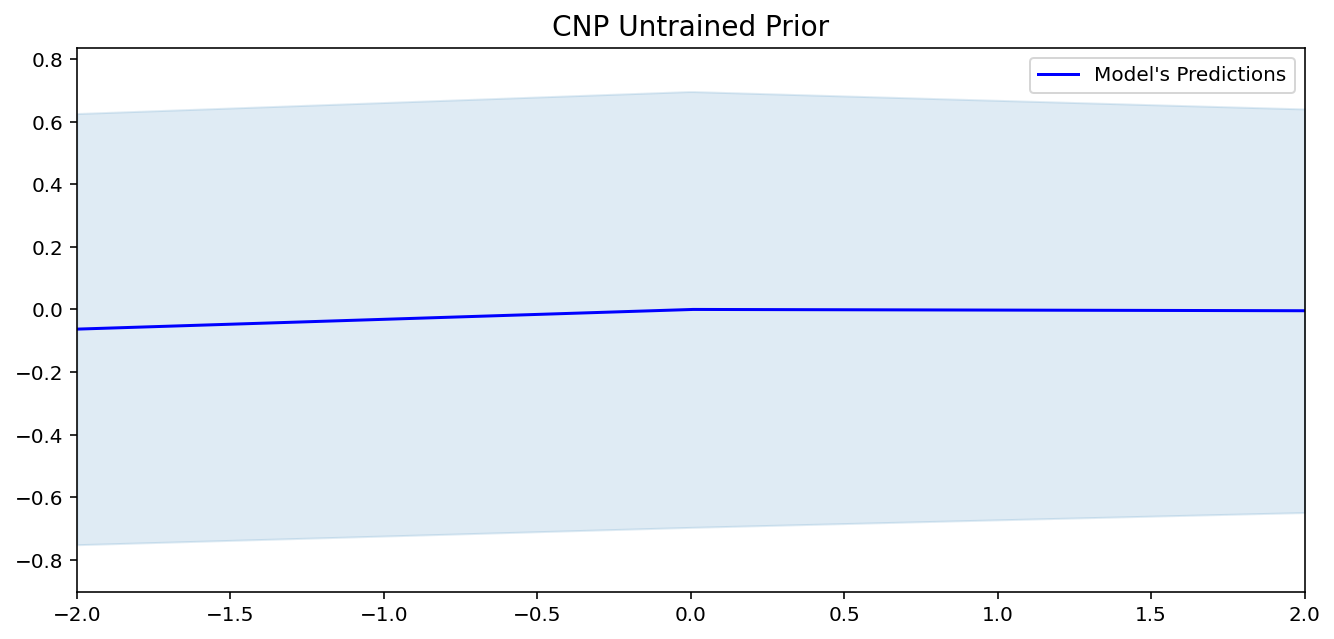

In [12]:
plot_prior_samples_1d(model(), train_min_max=dataset.min_max, title="CNP Untrained Prior", n_samples=1, is_plot_std=True)

# Training

Training is handled by [skorch](https://github.com/skorch-dev/skorch), which is a sklearn-style wrapper around pytorch. 

**Highltights**
- sklearn-style wrapper around pytorch. this is especially handy for downstream tasks to make a pipeline which does a task after being represented (i.e. transformed in sklearn jargon) by a CNP.
- many nice callbacks (including best model checkpoint used below)
- you can interrupt training and run again a cell: it will start where it last stoped


In [13]:
IS_RETRAIN = False  # whether to load precomputed model or retrain

In [14]:
import skorch
from neuralproc import CNPFLoss
from utils.data.dataloader import cntxt_trgt_collate
from utils.train import train_models

trainers = train_models(
    datasets,
    {"CNP": model},
    CNPFLoss,
    test_datasets=datasets_test,
    chckpnt_dirname="results/notebooks/neural_process/",
    is_retrain=IS_RETRAIN,
    iterator_train__collate_fn=cntxt_trgt_collate(
        get_cntxt_trgt
    ),  # collate function splits trgt and cntxt
    iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt),
    train_split=skorch.dataset.CVSplit(0.1),  # use 10% of data for validation
    device="cpu",  # use GPU if available
    max_epochs=20,  # large number of epochs as using early stopping
    batch_size=64,
    lr=1e-3,  # in the paper they use smaller batch size and lr but that is slow
    optimizer=torch.optim.Adam,
    callbacks=[skorch.callbacks.ProgressBar()],
    patience=5,  # use early stopping
    seed=123,  # make results determinisitic
)


--- Loading RBF_Kernel/CNP/run_0 ---



/private/home/yannd/projects/NPF/neuralproc/architectures/mlp.py:67: UserWarning: hidden_size=32 smaller than output=128 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


RBF_Kernel/CNP/run_0 | best epoch: 18 | train loss: 113.1352 | valid loss: 106.2167 | test log likelihood: -156.4491

--- Loading Periodic_Kernel/CNP/run_0 ---

Periodic_Kernel/CNP/run_0 | best epoch: 19 | train loss: 151.2498 | valid loss: 148.1948 | test log likelihood: -169.6367

--- Loading Matern_Kernel/CNP/run_0 ---

Matern_Kernel/CNP/run_0 | best epoch: 11 | train loss: 133.833 | valid loss: 128.1423 | test log likelihood: -160.8385

--- Loading Noisy_Matern_Kernel/CNP/run_0 ---

Noisy_Matern_Kernel/CNP/run_0 | best epoch: 18 | train loss: 170.6952 | valid loss: 168.4974 | test log likelihood: -162.6776


In [ ]:
n_trainers = len(trainers)
fig, axes = plt.subplots(
    n_trainers, 1, figsize=(11, 5 * n_trainers), sharex=True, sharey=True
)
for i, (k, trainer) in enumerate(trainers.items()):
    plot_losses(
        trainer.history,
        title="Losses for {}".format(k.split("/")[0].replace("_", " ")),
        ax=axes[i],
    )
    axes[i].set_ylim([-1, 300])
    axes[i].set_xlim([0, 100])

# Inference

## Trained Prior

The prior should now encode some information about the shapes of the functions. Neural processes can be thought of methods that learn an implicitkernel function from the data, if they are effective the trained prior should thus be very similar to the the samples the datasets previously seen.

In [17]:
INTERPOLATION_RANGE = dataset.min_max

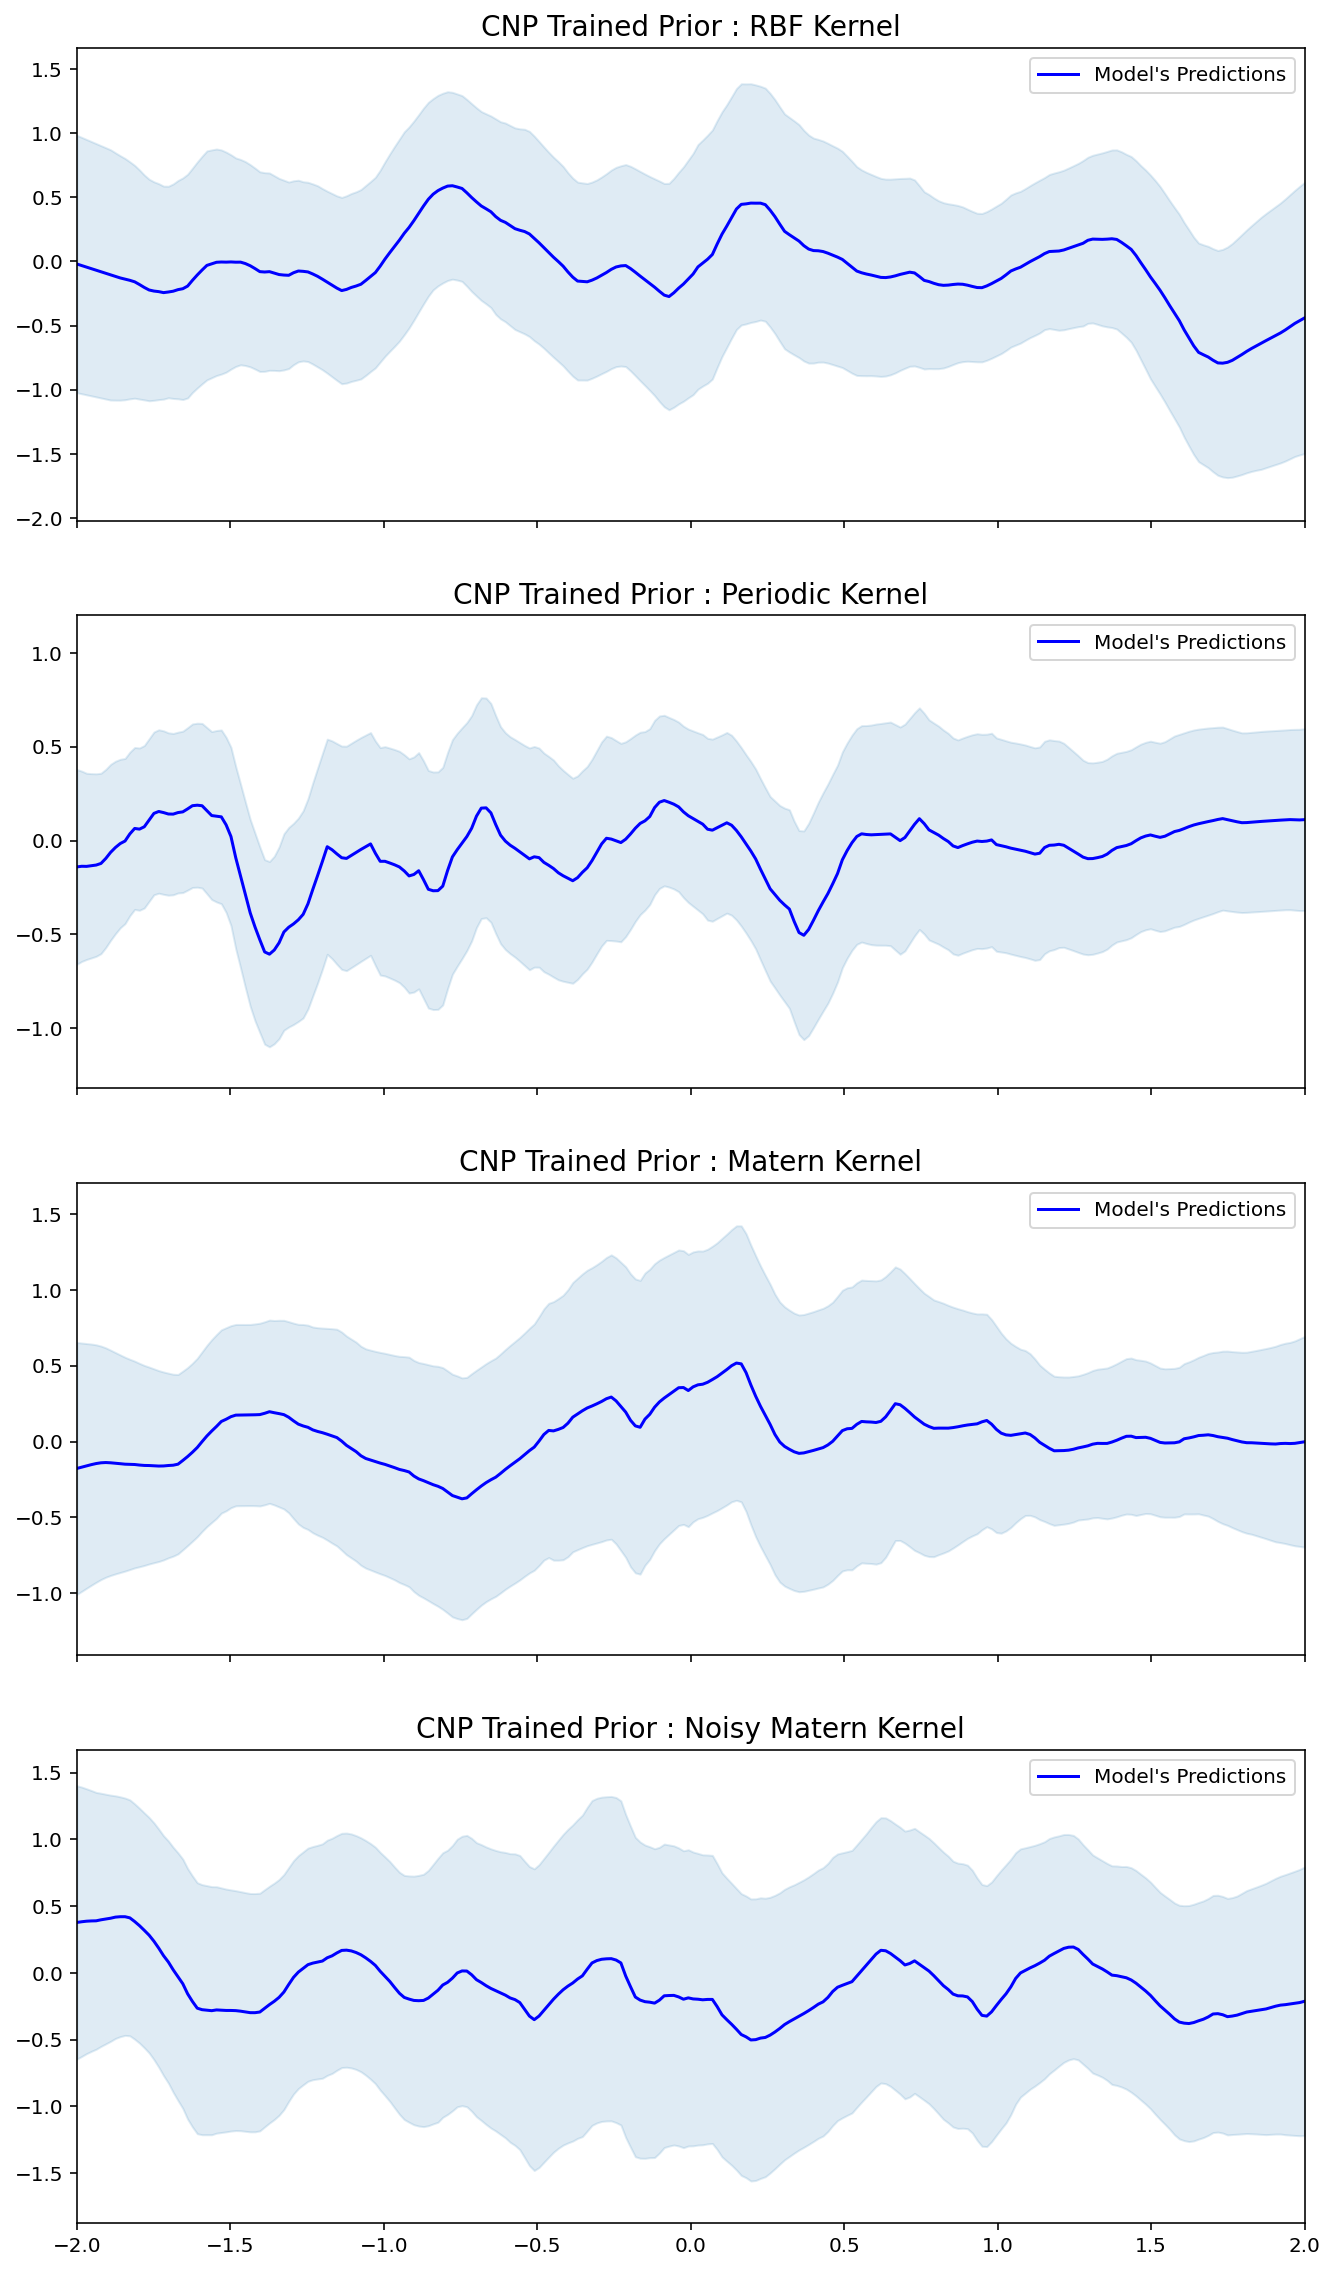

In [18]:
n_trainers = len(trainers)
fig, axes = plt.subplots(n_trainers, 1, figsize=(11, 5 * n_trainers), sharex=True)

for i, (k, trainer) in enumerate(trainers.items()):
    plot_prior_samples_1d(
        trainer.module_,
        title="CNP Trained Prior : {}".format(k.split("/")[0].replace("_", " ")),
        train_min_max=INTERPOLATION_RANGE,
        ax=axes[i],
        n_samples=1, 
        is_plot_std=True # you cannot sample with CNP so use 1 sample but plot std
    )

We see that the trained priors are not too bad but cannot learn very smooth samples (e.g. for all besides Matern).

## Posterior

Let us now investigate the posterior over functions when conditioned on some new context points.

In [ ]:
def get_n_cntxt(n_cntxt):
    return CntxtTrgtGetter(
        contexts_getter=GetRandomIndcs(min_n_indcs=n_cntxt, max_n_indcs=n_cntxt),
        targets_getter=get_all_indcs,
        is_add_cntxts_to_trgts=False,
    )

In [ ]:
N_CNTXT = 10
fig, axes = plt.subplots(n_trainers, 1, figsize=(11, 5 * n_trainers), sharex=True)

for i, (k, trainer) in enumerate(trainers.items()):
    data_name = k.split("/")[0]
    dataset = datasets[data_name]

    X, Y = dataset.get_samples(
        n_samples=1, n_points=3 * N_POINTS
    )  # use higher density for plotting

    plot_posterior_samples_1d(
        X,
        Y,
        get_n_cntxt(N_CNTXT),
        trainer.module_,
        generator=dataset.generator,
        n_samples=1,
        train_min_max=dataset.min_max,
        is_plot_std=True,
        title="CNP Posterior Conditioned on {} Context Points : {}".format(
            N_CNTXT, data_name.replace("_", " ")
        ),
        ax=axes[i],
    )

In [ ]:
N_CNTXT = 30
fig, axes = plt.subplots(n_trainers, 1, figsize=(11, 5 * n_trainers), sharex=True)

for i, (k, trainer) in enumerate(trainers.items()):
    data_name = k.split("/")[0]
    dataset = datasets[data_name]

    X, Y = dataset.get_samples(
        n_samples=1, n_points=3 * N_POINTS
    )  # use higher density for plotting

    plot_posterior_samples_1d(
        X,
        Y,
        get_n_cntxt(N_CNTXT),
        trainer.module_,
        generator=dataset.generator,
        n_samples=1,
        train_min_max=dataset.min_max,
        is_plot_std=True,
        title="CNP Posterior Conditioned on {} Context Points : {}".format(
            N_CNTXT, data_name.replace("_", " ")
        ),
        ax=axes[i],
    )

We see that the model learned something but the predictions are pretty bad.

**Good**:
- The standard devation does not collapse to the minimum value it can output . 
- It is also relatively uncertain far from context points. 
- Results improve with more context points.

**Bad**:
- it underfits : the mean does not always pass through the context points and the variance doesn't decrease at those points.
- periodicity pattern is not periodic